In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import os
import scipy.stats as scs
import os.path
from os import path

In [2]:
def kde(a, w):
    min_ = np.min(a)
    max_ = np.max(a)
    x = np.linspace( min_, max_, num = 50 )
    d = scs.gaussian_kde( a, bw_method = "silverman", weights = w ).evaluate(x)
    u = 1./np.average(1./a, weights = w)
    return x,d,u

### Building dataset

In [3]:
dataset = {
    'name': ('Hst5','Sic1','aSyn','Tau','ProTa','GHR-ICD','NHE6cmdd','ANAC046','DSS1','RS'),
    'length': (24, 90, 140, 441, 110, 351, 116, 167, 71, 24),
    'ensemble_size': (10000, 15000, 20000, 30000, 15000, 25000, 15000, 20000, 15000, 10000),
    'Rh': (1.275, 2.15, 2.86, 5.20, 2.89, 5.18, 2.66, 3.04, 1.99, 1.19),
    'Rh_err': (0.024, 0.11, 0.07, 0.2, 0, 0, 0, 0.01, 0, 0.01)
}
dataset = pd.DataFrame(dataset).sort_values('length').set_index('name')
dataset.to_csv('/storage1/francesco/PROJECTS/EXP_DATA/Rh.csv')

In [4]:
dataset

,length,ensemble_size,Rh,Rh_err
name,,,,
Hst5,24,10000,1.275,0.024
RS,24,10000,1.190,0.010
DSS1,71,15000,1.990,0.140
Sic1,90,15000,2.150,0.110
ProTa,110,15000,2.890,0.080
NHE6cmdd,116,15000,2.660,0.000
aSyn,140,20000,2.860,0.070
ANAC046,167,20000,3.040,0.010
GHR-ICD,351,25000,5.180,0.000


In [7]:
# Maybe use this error for data where the error is not reported?
frac_err = (dataset[dataset.Rh_err != 0].Rh_err / dataset[dataset.Rh_err != 0].Rh).mean()
print(frac_err)
for i in dataset.index:
    if dataset.Rh_err[i] == 0:
        dataset.loc('Rh_err')[i] = dataset.Rh[i]*frac_err

0.030331204721109284


In [6]:
exp_saxs = [
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/Hst5/saxs293k_bme.txt'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/RS/exp_saxs.txt'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/DSS1/bift_saxs.txt'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/Sic1/exp_saxs.txt'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/ProTa/bift_saxs.txt'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/NHE6cmdd/bift_saxs.txt'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/aSyn/exp_saxs.txt'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/ANAC046/exp_saxs.txt'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/GHR-ICD/exp_saxs_150mM_1p7mg.dat'),
    np.loadtxt('/storage1/francesco/PROJECTS/EXP_DATA/Tau/exp_saxs.txt')
]
dataset['exp_saxs'] = exp_saxs

for p in dataset.index:
    if dataset.exp_saxs[p][...,0][-1] < 1:
        dataset.exp_saxs[p][...,0] *= 10

### Analyse iBME(SAXS) results

In [11]:
import matplotlib.colors

def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = matplotlib.colors.ListedColormap(cols)
    return cmap

c1 = categorical_cmap(19, 1, cmap="tab20")

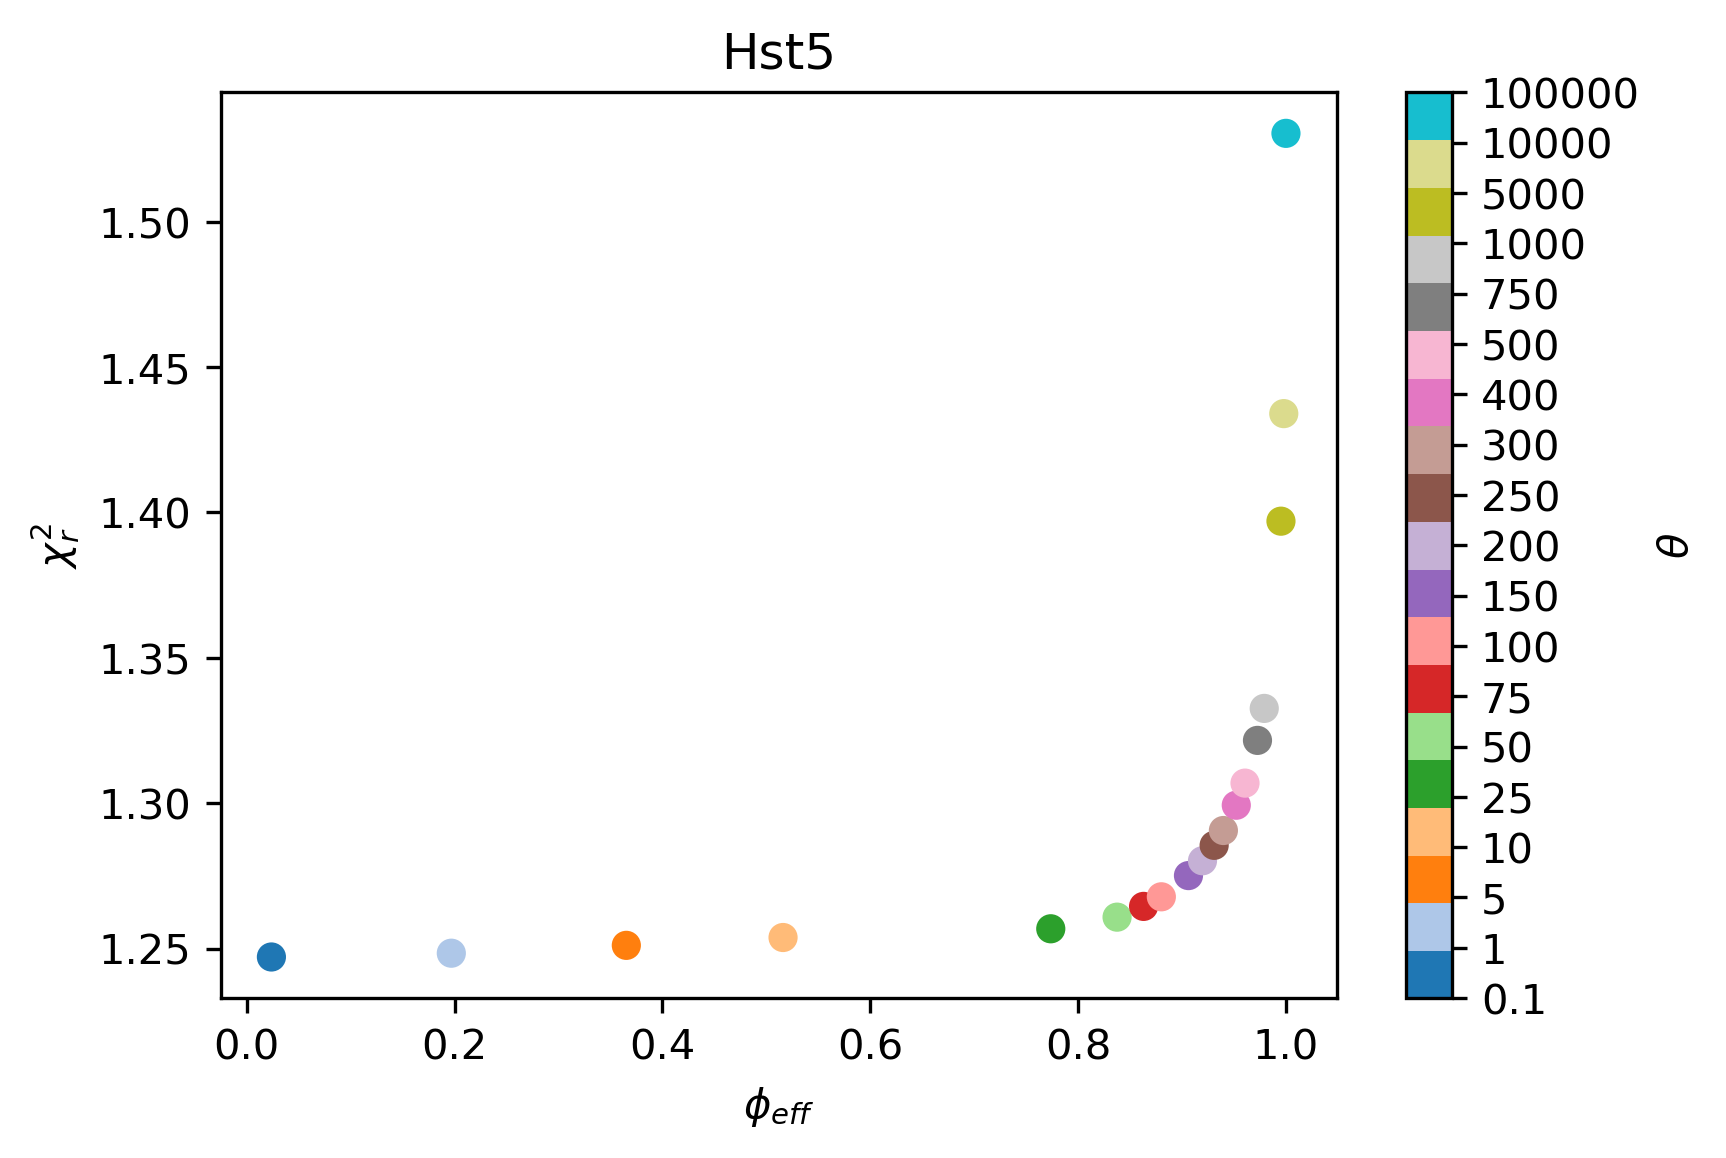

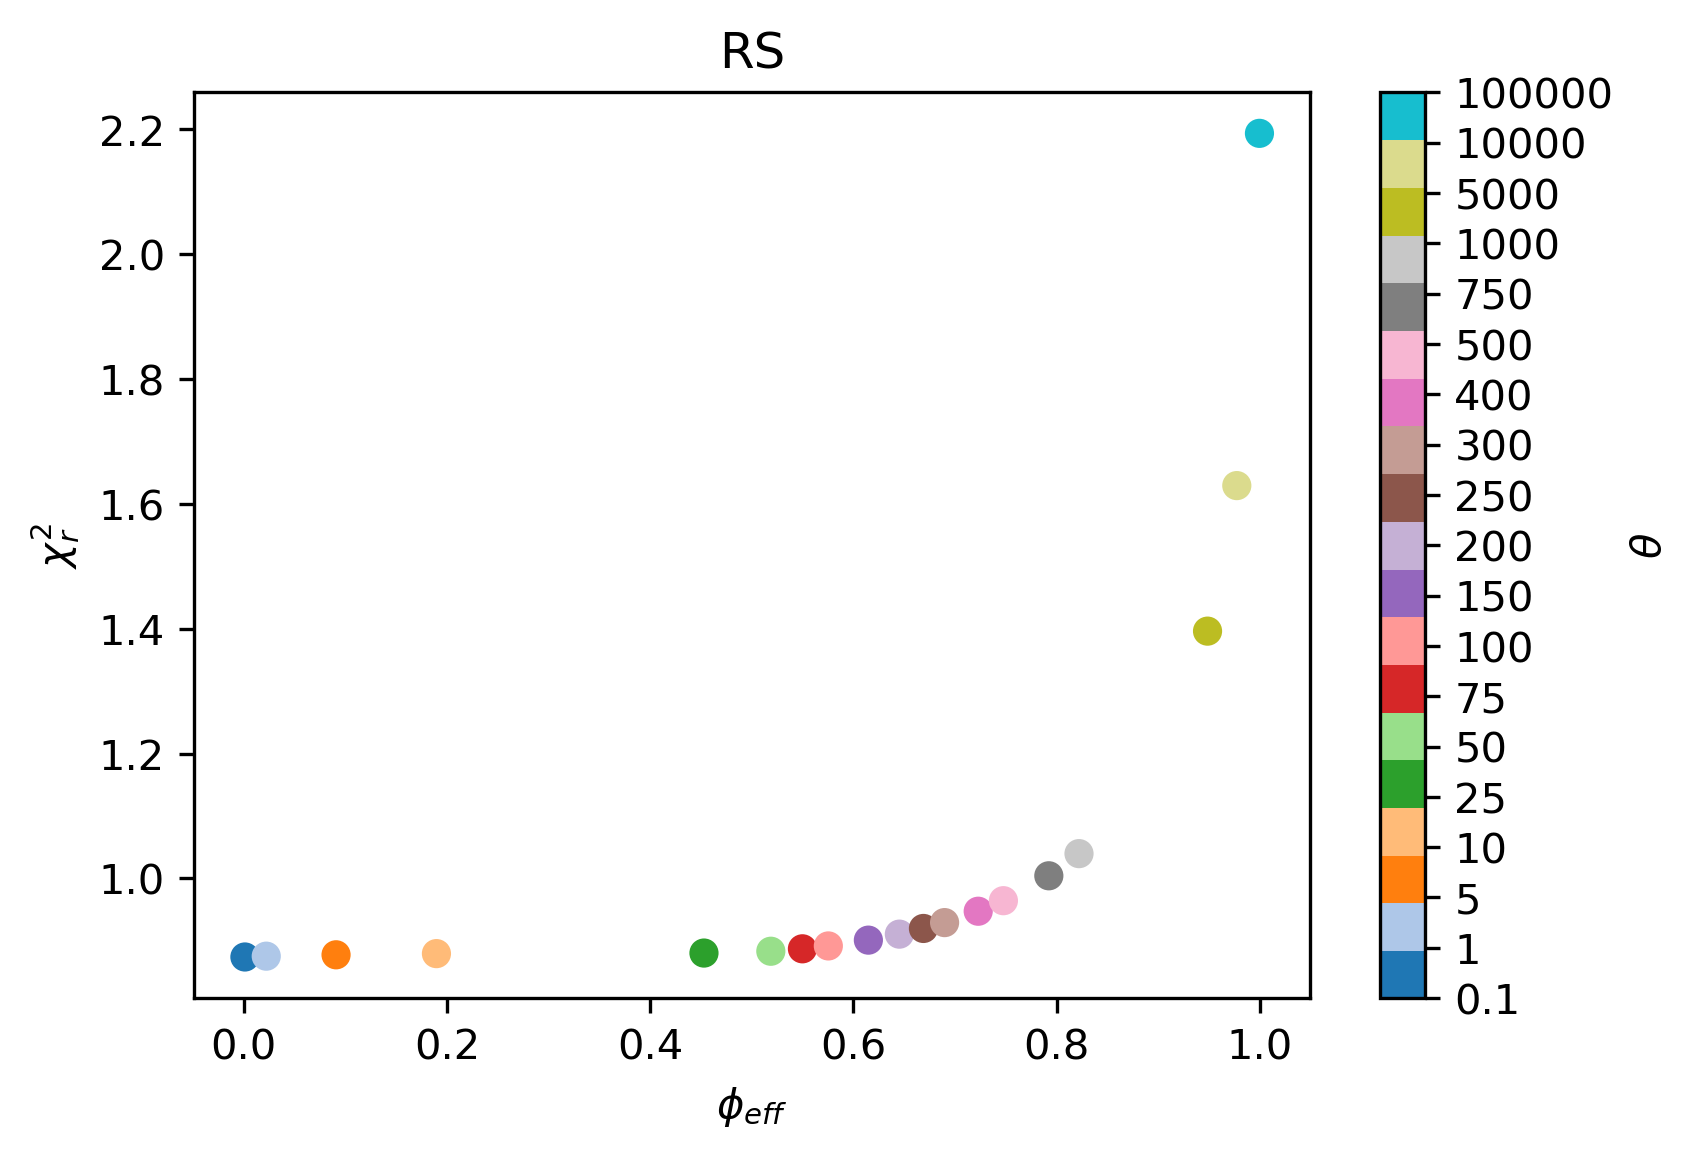

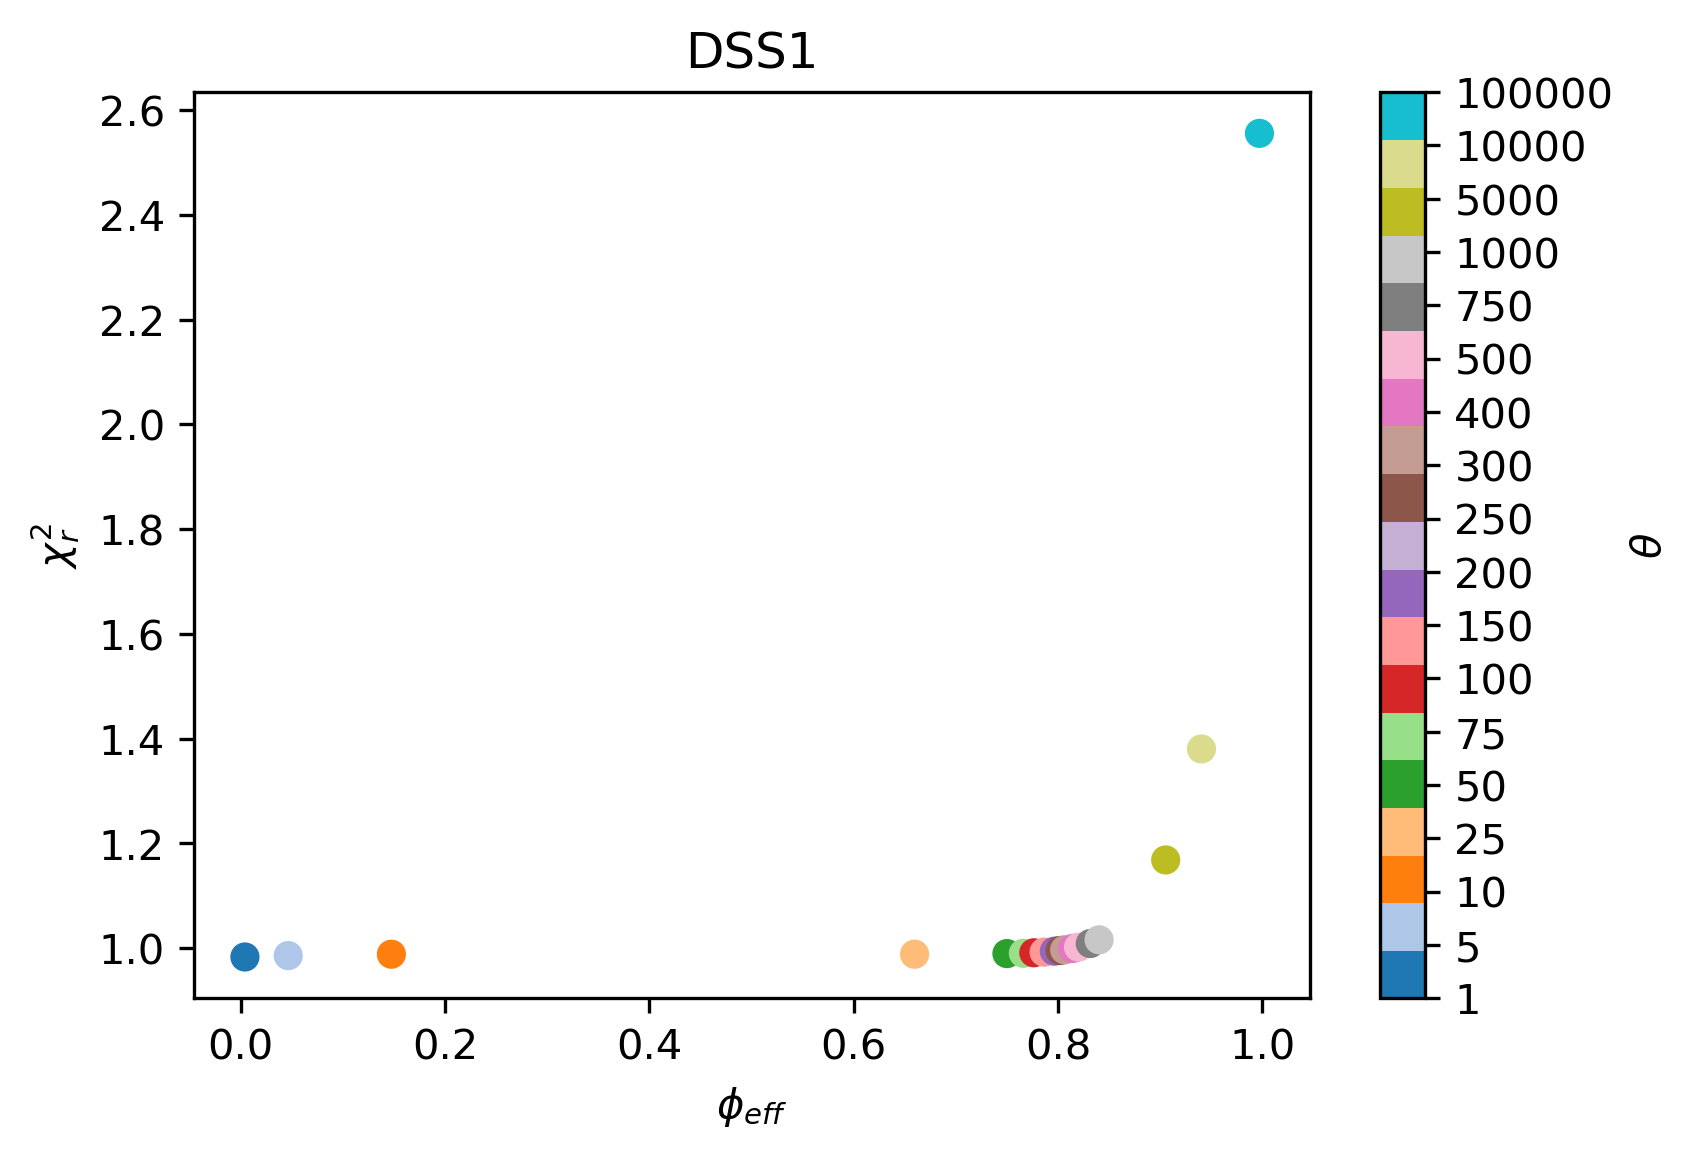

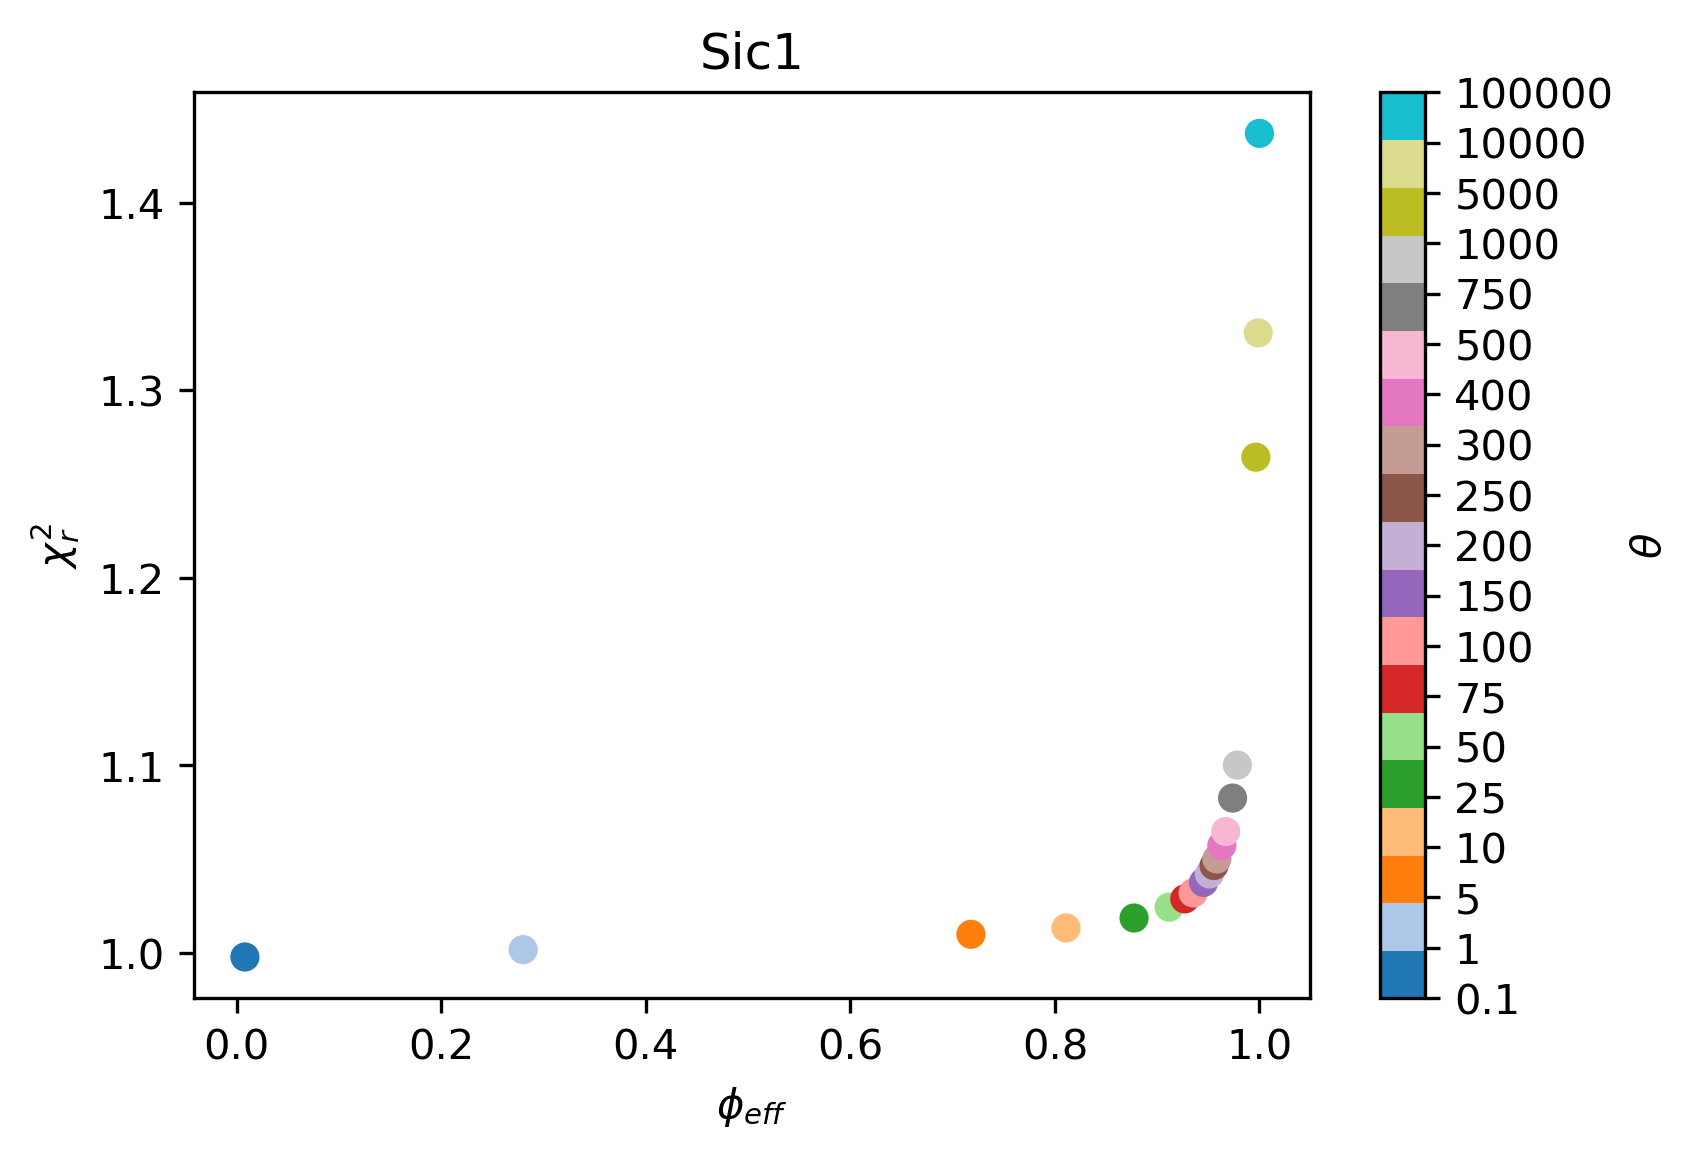

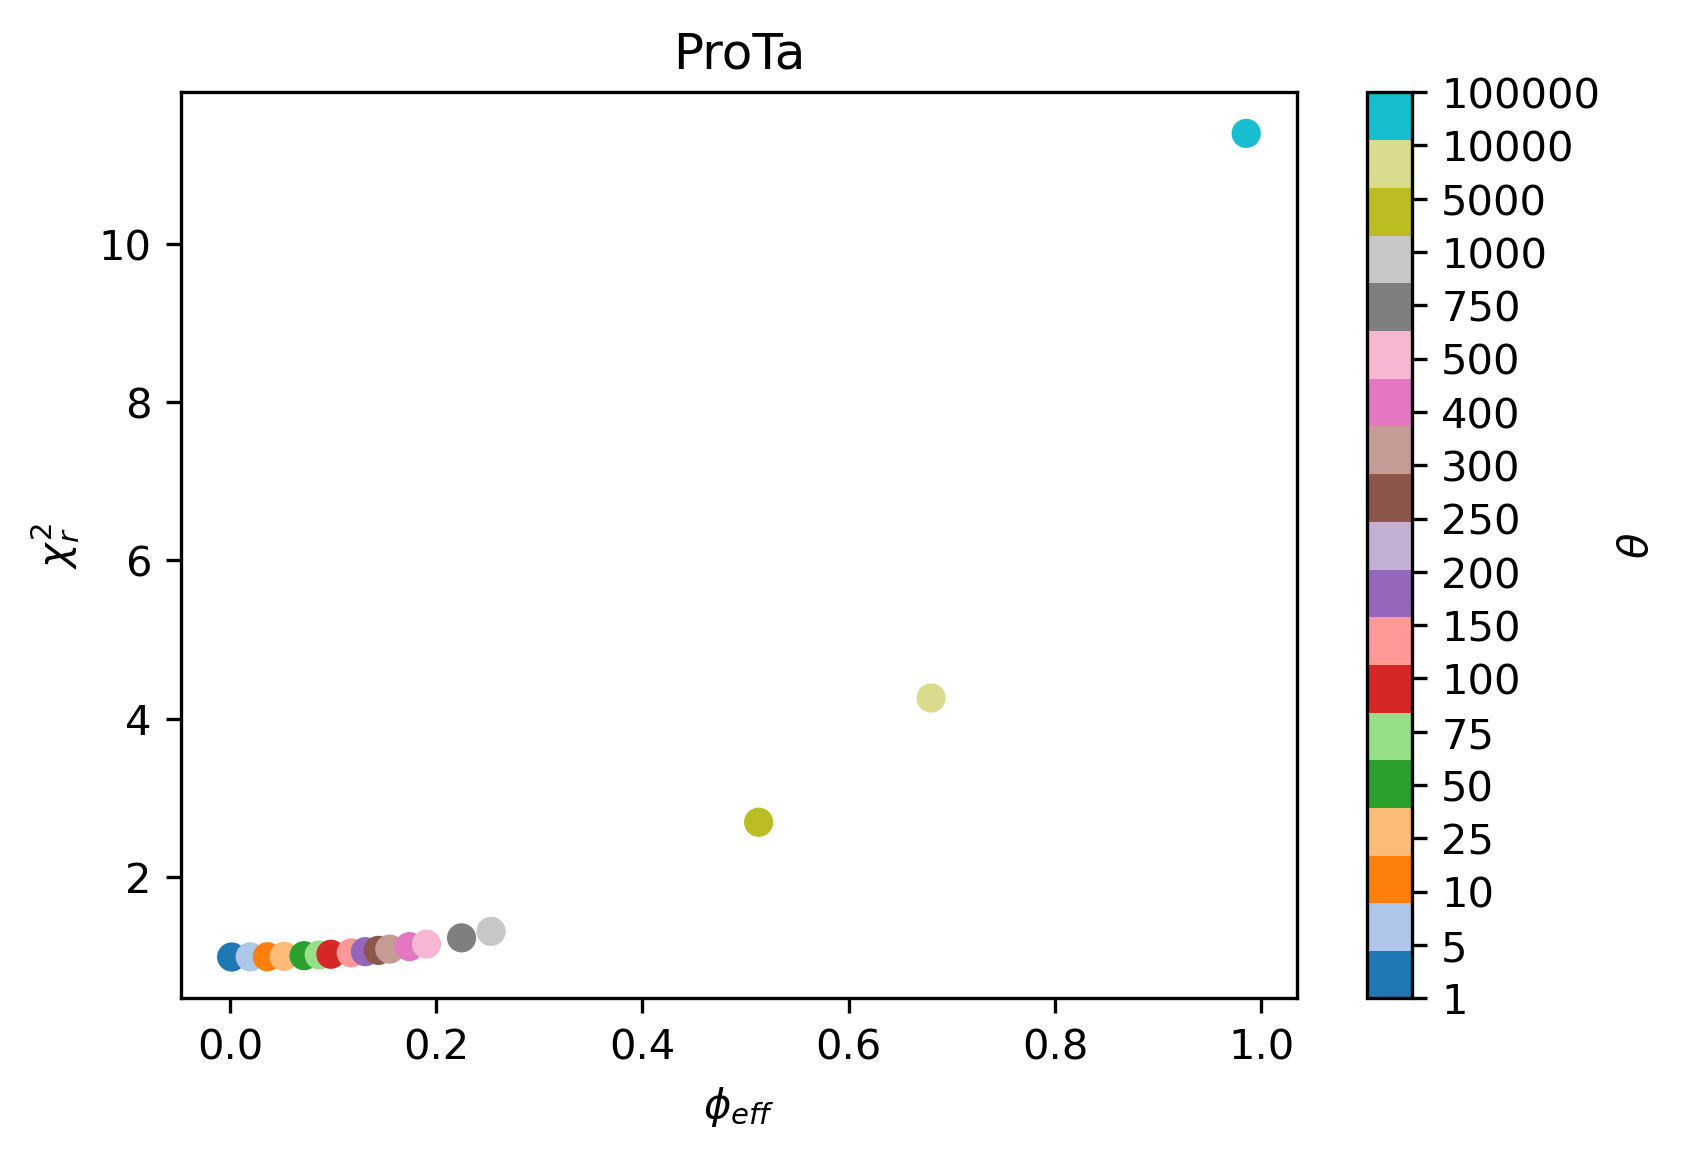

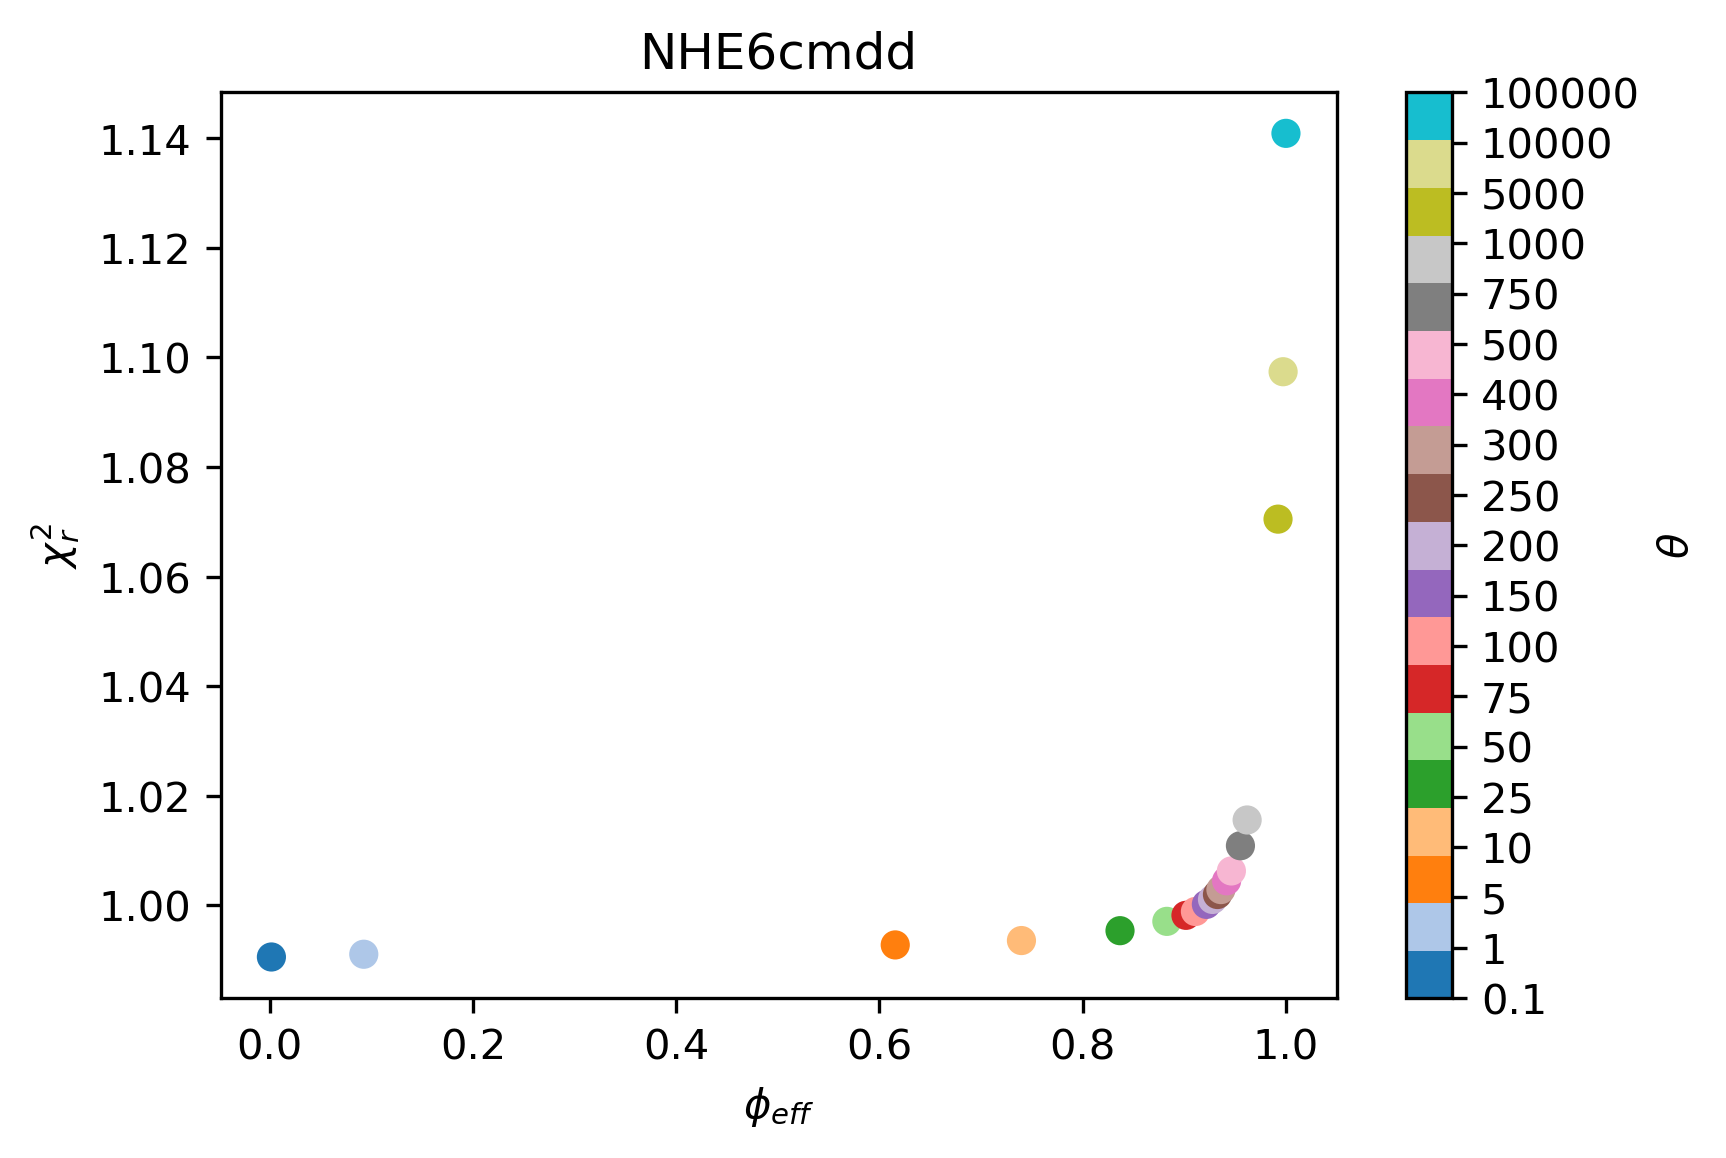

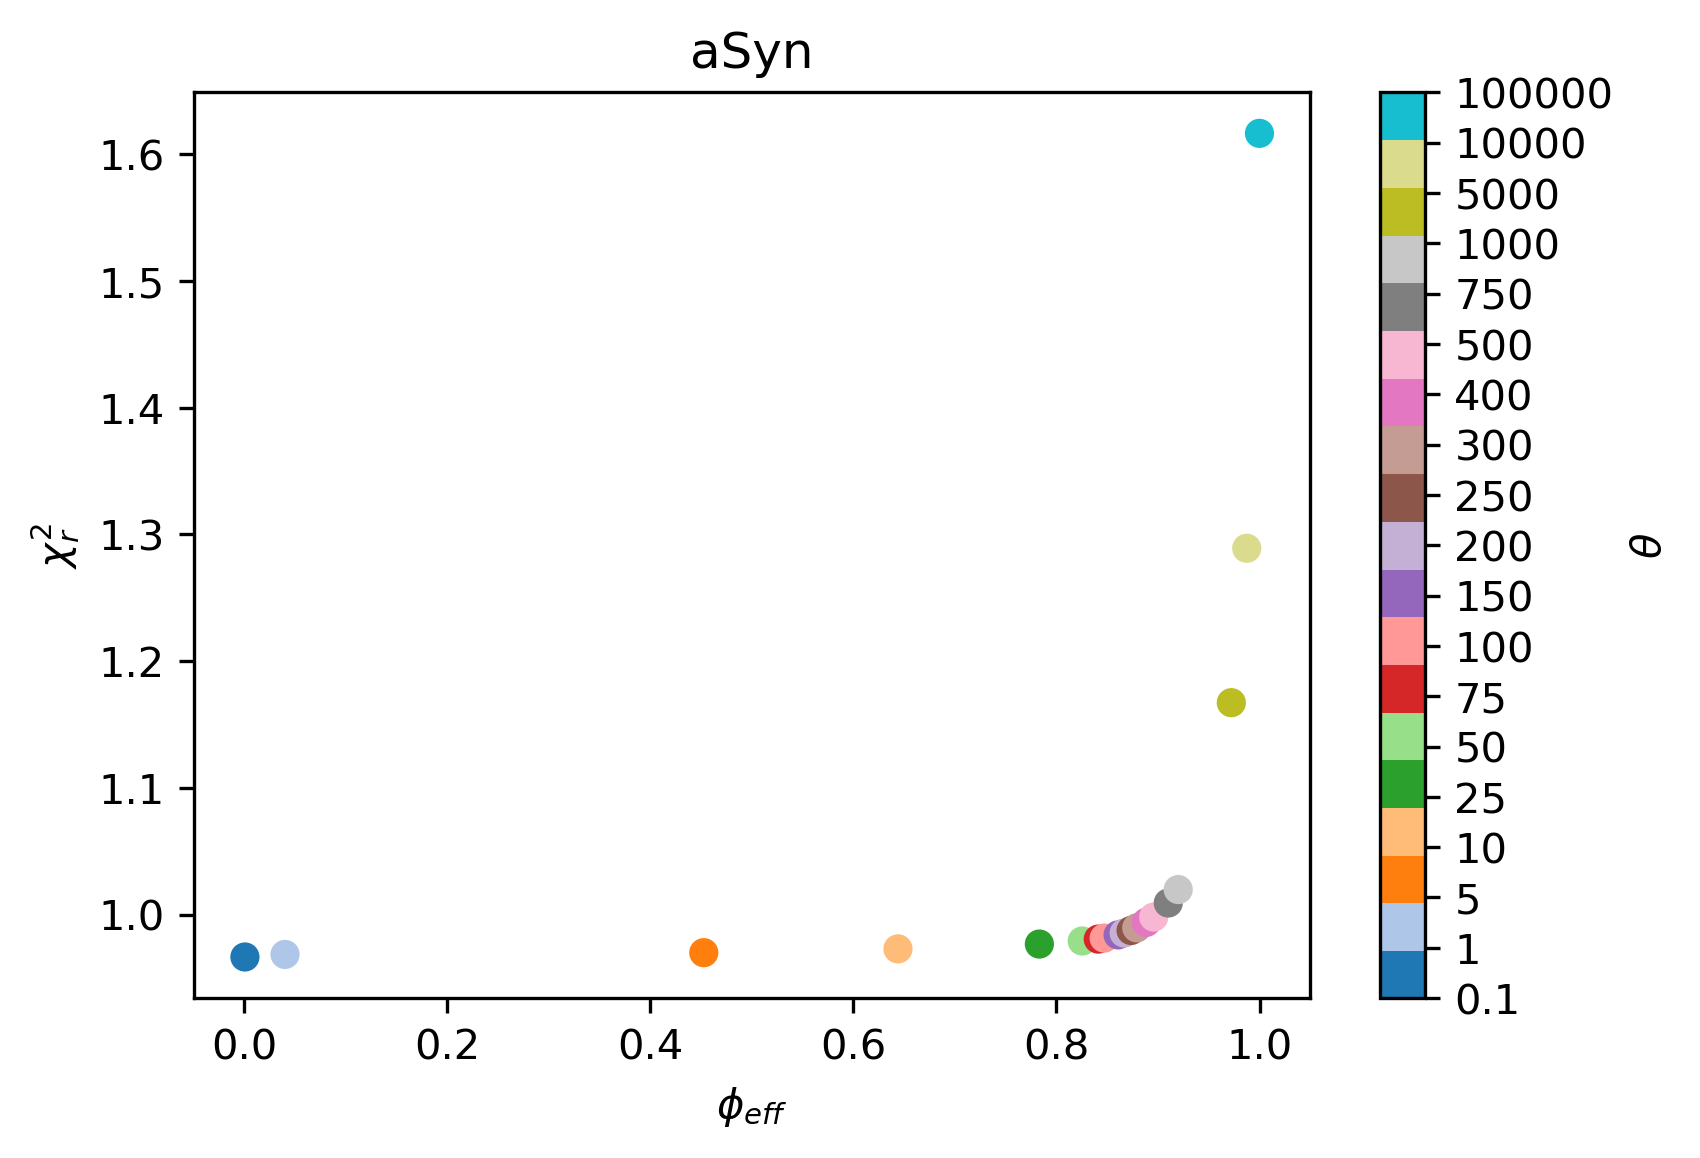

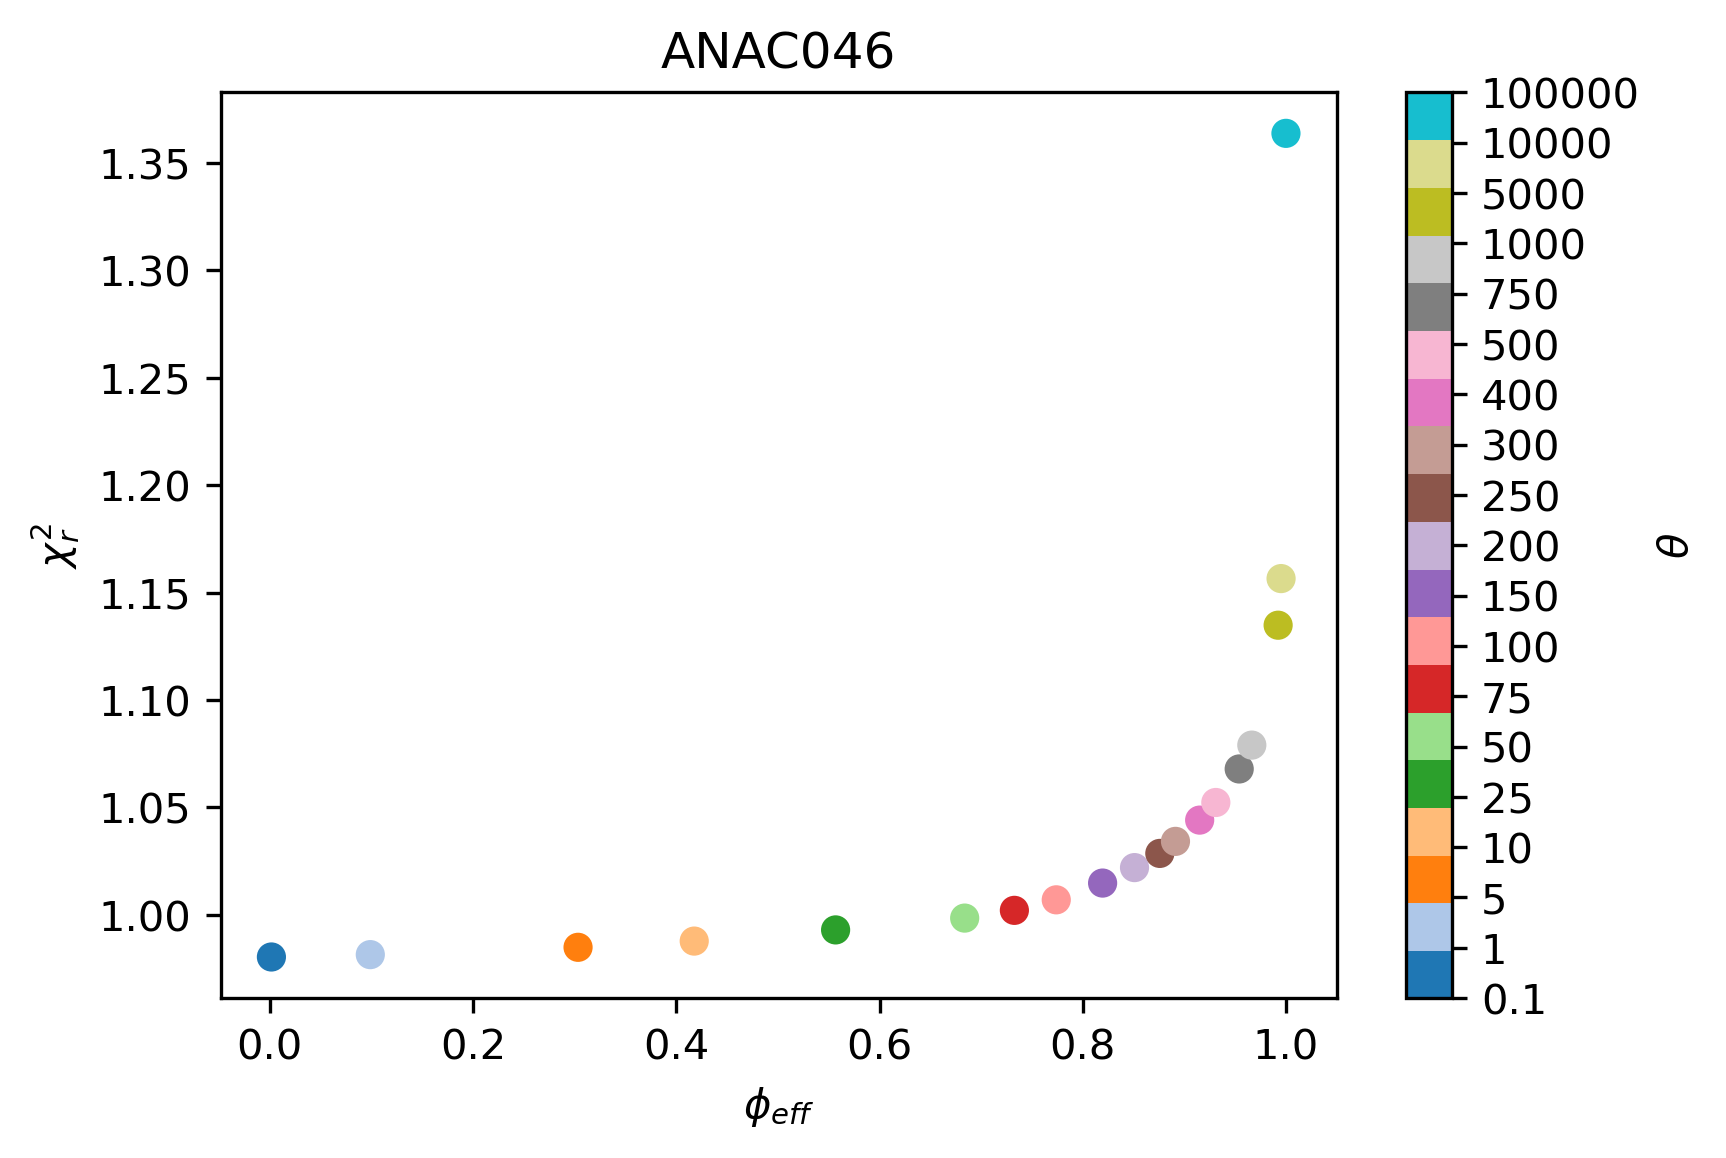

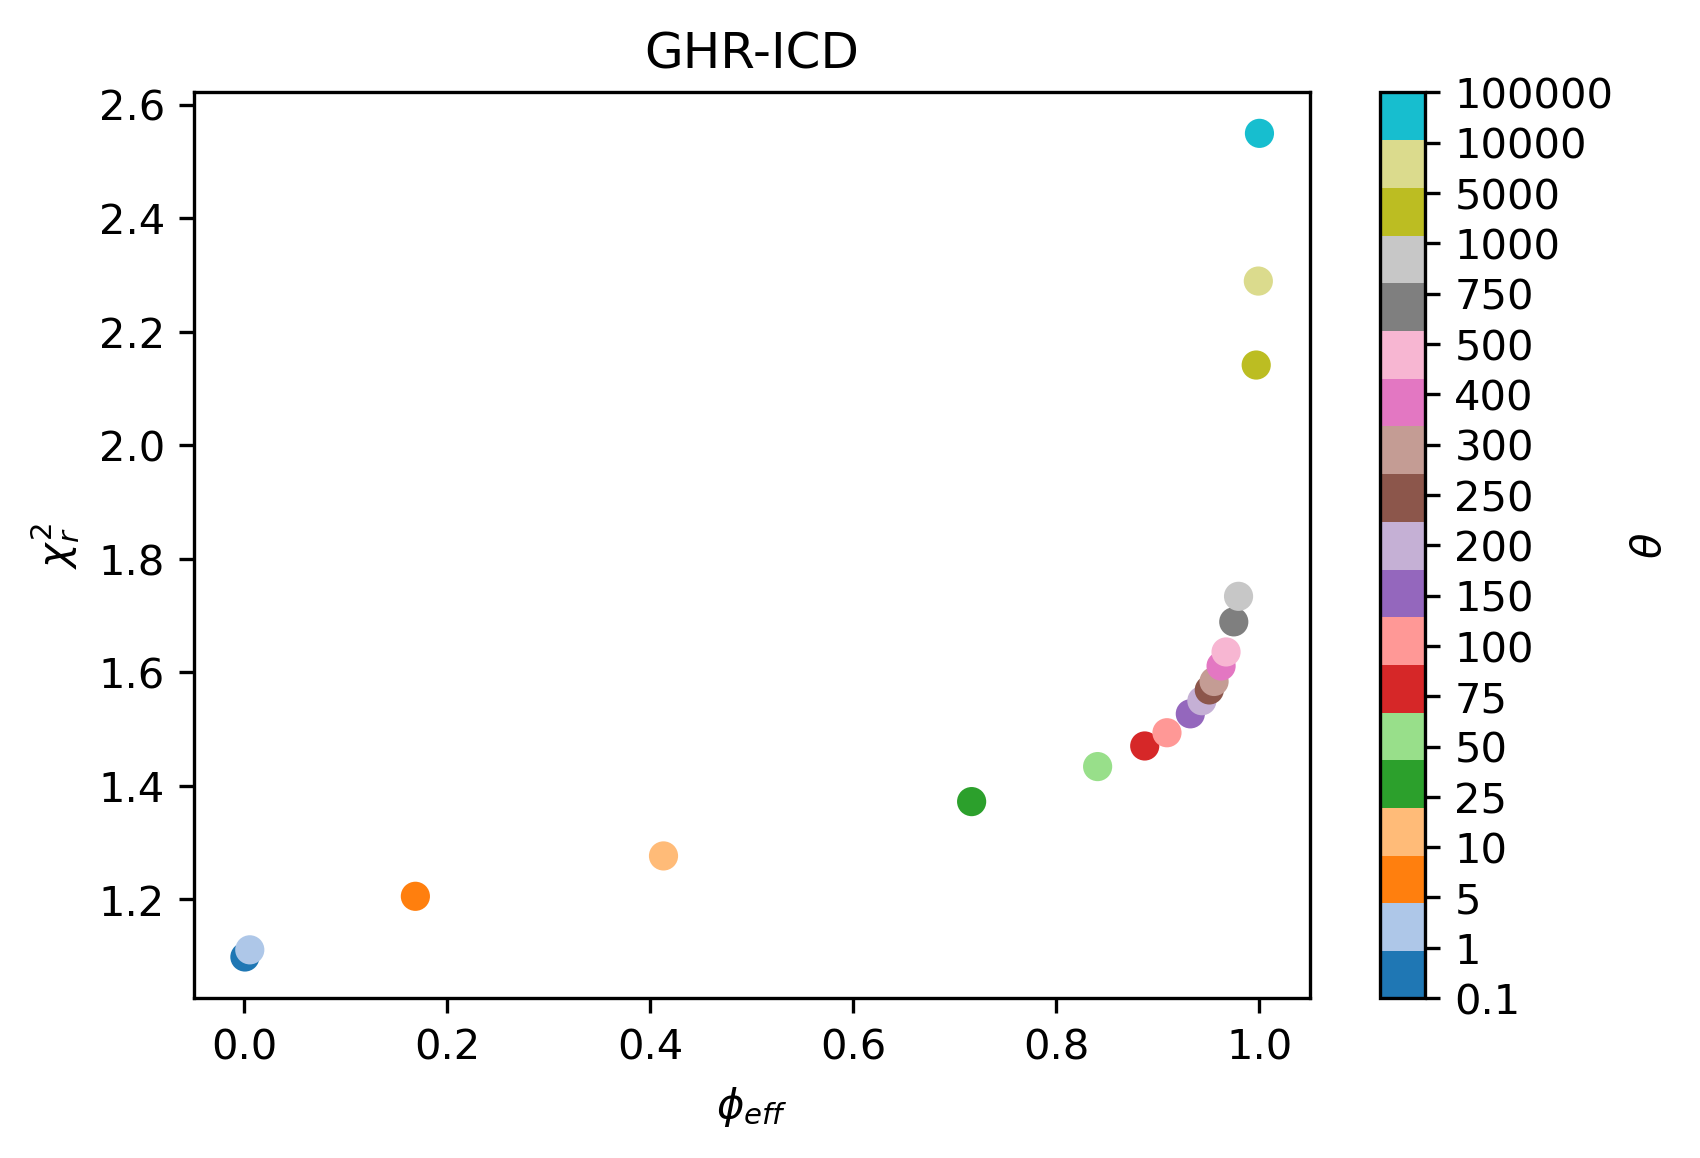

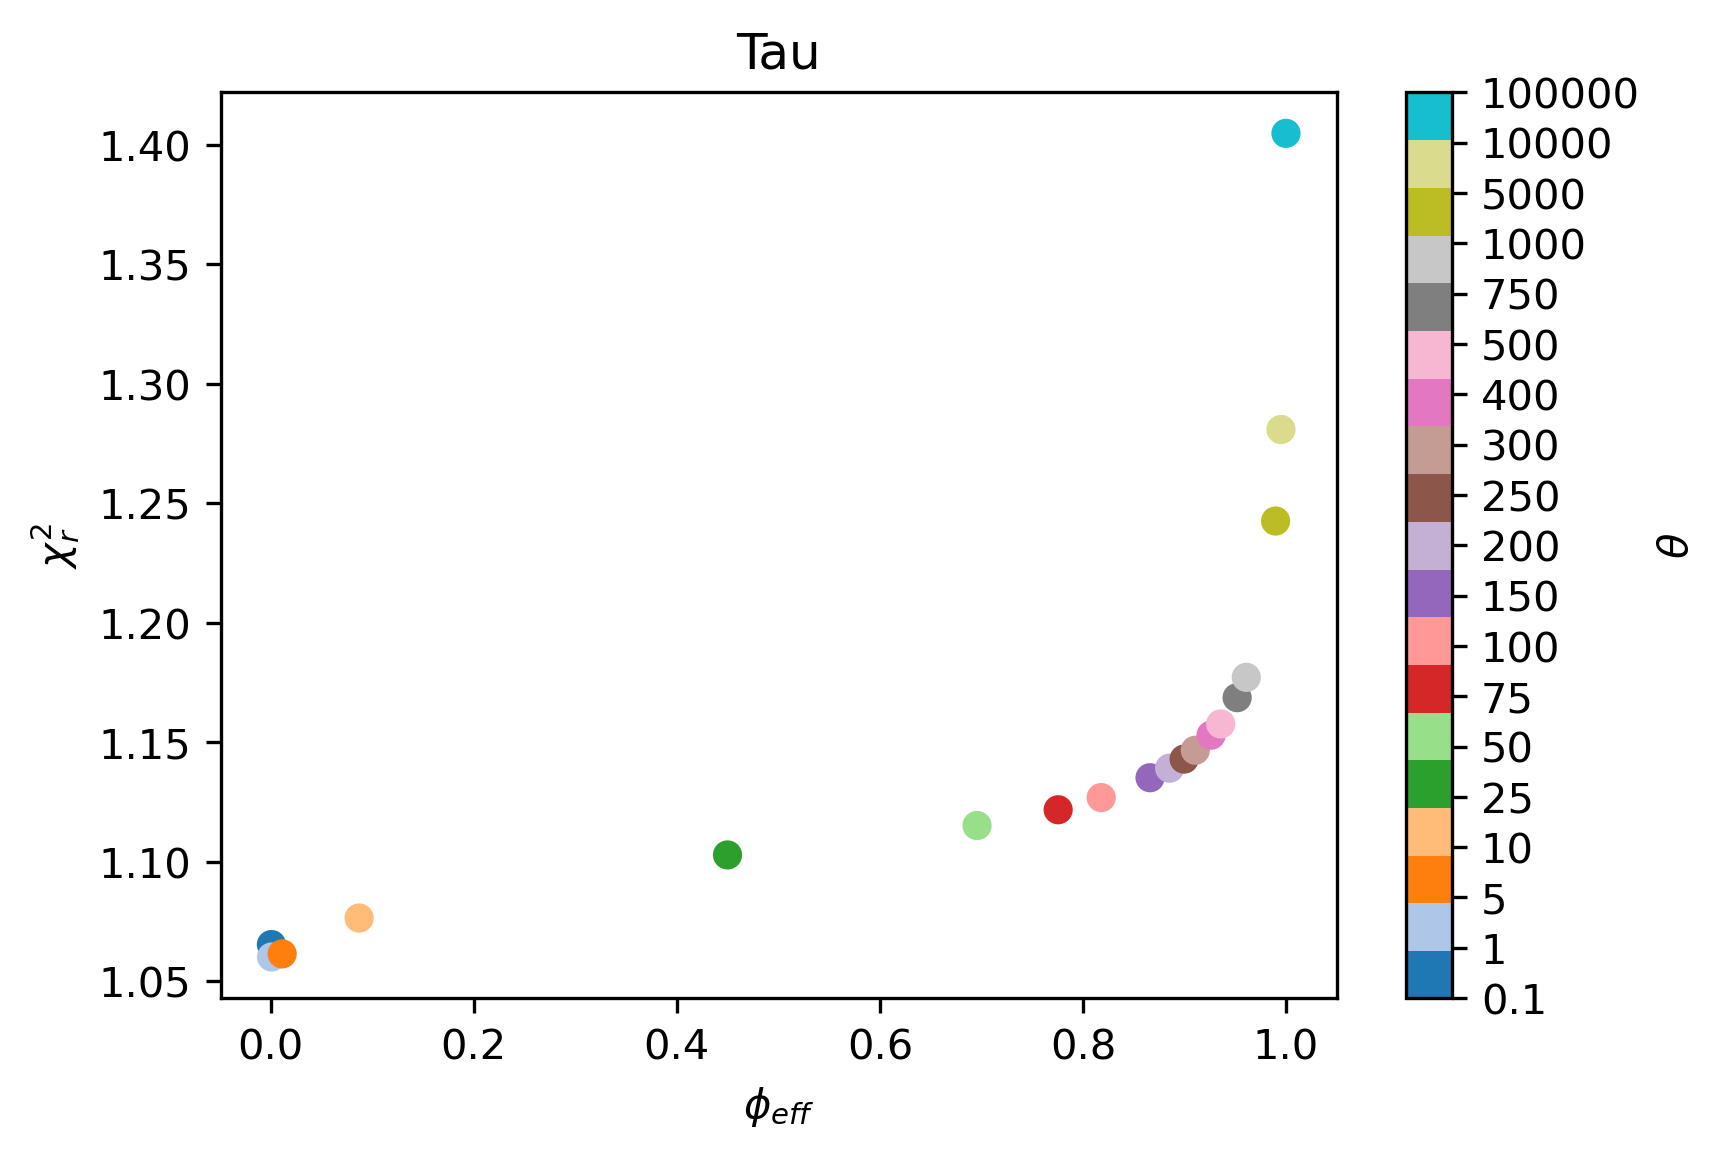

In [12]:
thetas = [ 0.1, 1, 5, 10, 25, 50, 75, 100, 150, 200, 250, 300, 400, 500, 750, 1000, 5000, 10000, 100000  ]
BME_tscan = {}
for idp in dataset.index:
    BME_tscan[idp] = []
    for t in thetas:
        f_ = list(filter(lambda x: x.startswith('t'+str(t)+'_ibme_'), os.listdir(idp+'/BME')))
        f_.sort( key=lambda x: int(x[:-4].split('_')[2]) )
        for l in open(idp+'/BME/'+f_[-1], 'r').readlines():
            if l.startswith('CHI2 after optimization:'):
                chi2 = float(l.split()[-1])
            elif l.startswith('Fraction of effective frames:'):
                phi = float(l.split()[-1])
        BME_tscan[idp].append([t,chi2,phi])
    
    tscan = np.array(BME_tscan[idp])
    plt.fig = plt.figure(dpi=300)
    plt.scatter(tscan[...,2], tscan[...,1], c=range(len(tscan)), cmap=plt.get_cmap(c1))
    cbar = plt.colorbar(ticks=range(len(tscan)), label=r'$\theta$', spacing='uniform')
    cbar.ax.set_yticklabels(thetas)
    plt.title(idp)
    plt.xlabel(r'$\phi_{eff}$')
    plt.ylabel(r'$\chi^2_r$')
    plt.show()

In [13]:
#Choice of thetas
dataset['theta'] = [50, 750, 1000, 50, 5000, 50, 300, 100, 50, 100]

In [14]:
w = []
calc_saxs = []
for idp in dataset.index:
    f_ = list(filter(lambda x: x.startswith('t'+str(dataset.theta[idp])+'_ibme_'), os.listdir(idp+'/BME')))
    f_.sort( key=lambda x: int(x[:-4].split('_')[2]) )
    conv_ndx = f_[-1][:-4].split('_')[2]
    w.append( np.loadtxt(idp+'/BME/t'+str(dataset.theta[idp])+'_'+str(conv_ndx)+'.weights.dat')[...,1] )
    calc_saxs.append( np.loadtxt(idp+'/BME/t'+str(dataset.theta[idp])+'_'+str(conv_ndx)+'.calc.dat')[...,1:] )
dataset['weights'] = w
dataset['calc_saxs'] = calc_saxs

In [30]:
ndx = dataset.exp_saxs['Hst5'][...,0] < 1 

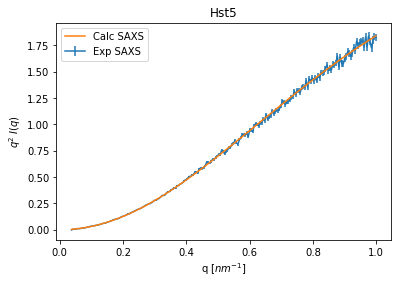

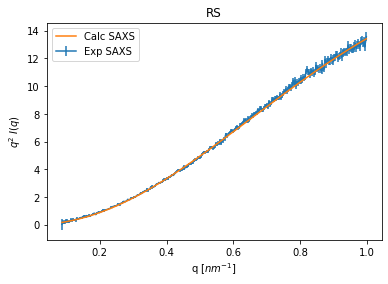

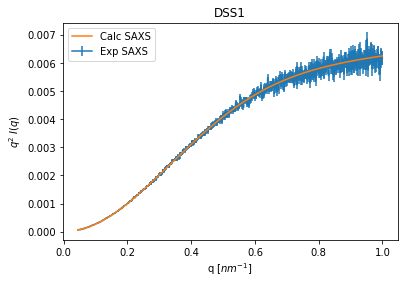

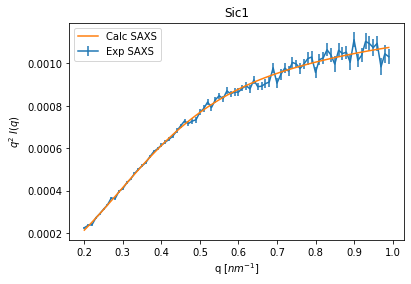

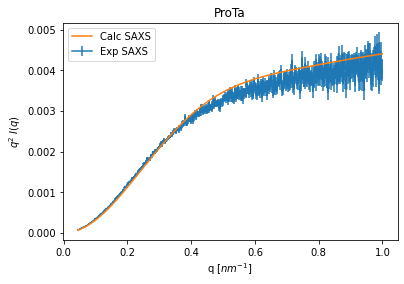

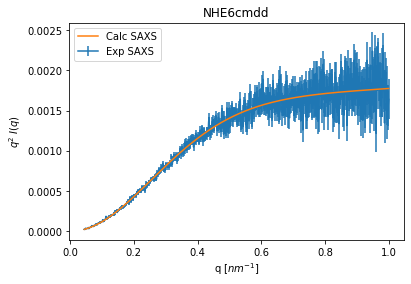

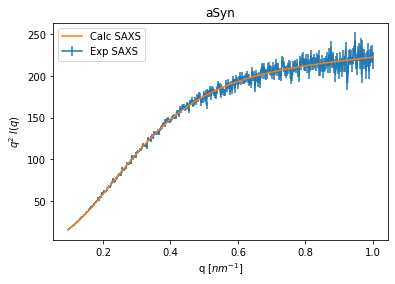

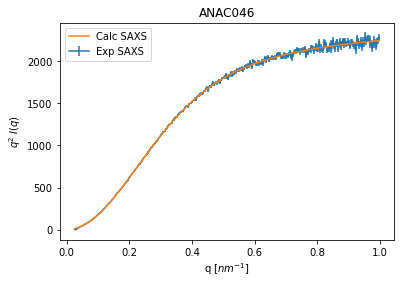

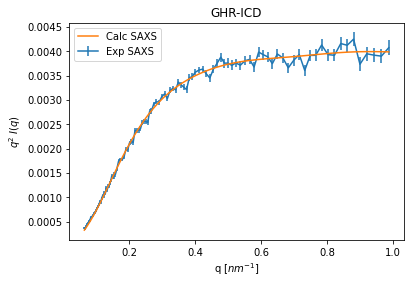

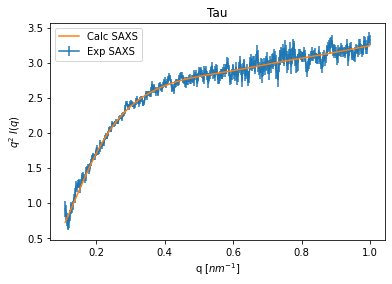

In [33]:
for p in dataset.index:
    ndx = dataset.exp_saxs[p][...,0] < 1 
    
    q = dataset.exp_saxs[p][...,0]
    kratky_exp = (q**2)*dataset.exp_saxs[p][...,1]
    kratky_err = (q**2)*dataset.exp_saxs[p][...,2]
    calc_i = np.average( dataset.calc_saxs[p], weights=dataset.weights[p], axis=0 )
    kratky_calc = (q**2)*calc_i
    
    plt.errorbar(q[ndx] ,kratky_exp[ndx] ,kratky_err[ndx], label='Exp SAXS')
    plt.plot(q[ndx], kratky_calc[ndx] ,zorder=100, label='Calc SAXS')
    plt.legend()
    plt.xlabel(r'q [$nm^{-1}$]')
    plt.ylabel(r'$q^2$ $I(q)$')
    plt.title(p)
    #plt.savefig(p+'_saxs.png', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
    plt.show()

### Rh forward models comparison

In [34]:
Rh_Nyg = {}
Rh_Kirk = {}
Rh_HR = {}
Rh_KirkNyg = {}
for p in dataset.index:
    Rh_Nyg[p] = kde( np.loadtxt(p+'/Rh_Nyg.dat')/10, dataset.weights[p] )
    Rh_Kirk[p] = kde( np.loadtxt(p+'/Rh_Kirk.dat'), dataset.weights[p] )
    Rh_HR[p] = kde( np.loadtxt(p+'/Rh_HR.dat'), dataset.weights[p])
    Rh_KirkNyg[p] = kde( np.loadtxt(p+'/Rh_Kirk.dat')*1.186+0.103, dataset.weights[p] )

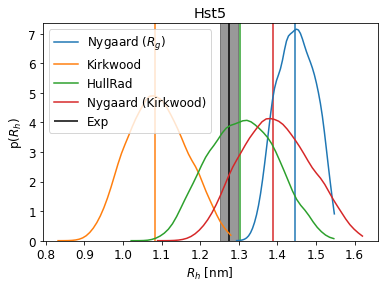

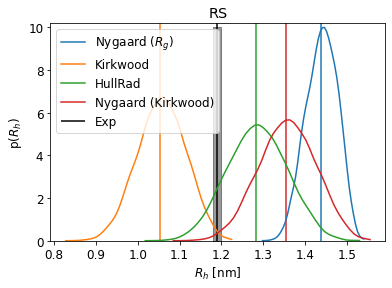

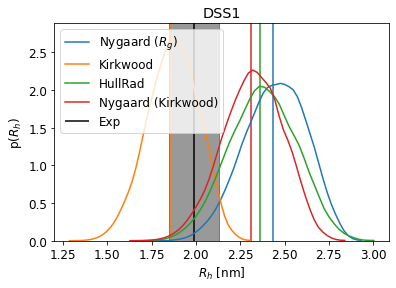

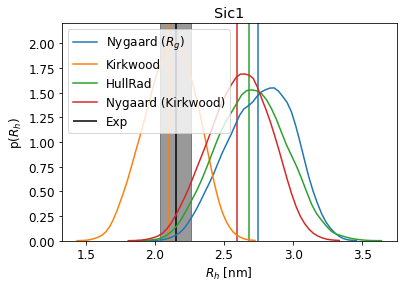

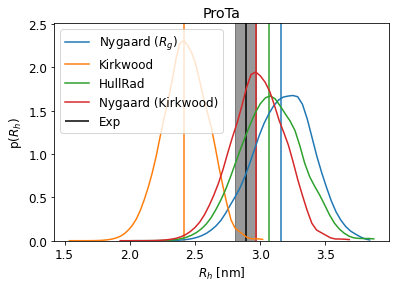

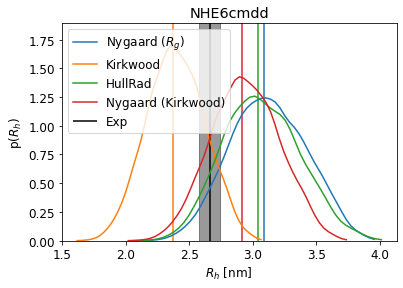

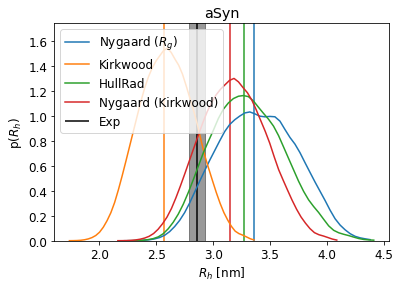

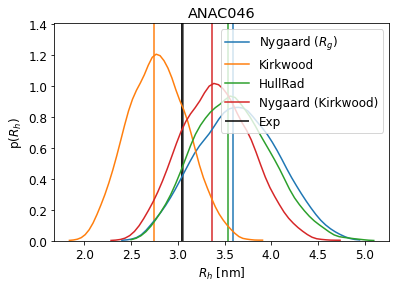

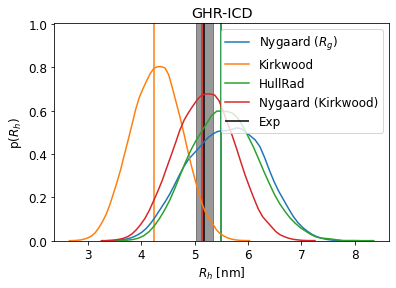

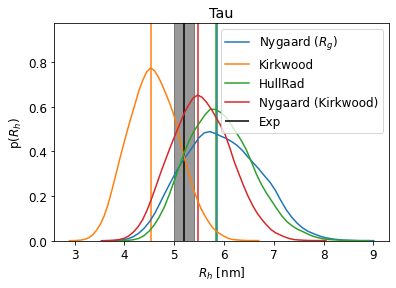

In [36]:
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['font.size'] = 12
for p in dataset.index:
    
    plt.plot(Rh_Nyg[p][0], Rh_Nyg[p][1], label=r'Nygaard ($R_g$)',color=c[0])
    plt.vlines(Rh_Nyg[p][2],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,color=c[0])
    
    plt.plot(Rh_Kirk[p][0], Rh_Kirk[p][1], label='Kirkwood',color=c[1])
    plt.vlines(Rh_Kirk[p][2],Rh_Kirk[p][1].min()-1,Rh_Kirk[p][1].max()+10,color=c[1])
    
    plt.plot(Rh_HR[p][0], Rh_HR[p][1], label='HullRad',color=c[2])
    plt.vlines(Rh_HR[p][2],Rh_HR[p][1].min()-1,Rh_HR[p][1].max()+10,color=c[2])
    
    plt.plot(Rh_KirkNyg[p][0], Rh_KirkNyg[p][1], label='Nygaard (Kirkwood)',color=c[3])
    plt.vlines(Rh_KirkNyg[p][2],Rh_KirkNyg[p][1].min()-1,Rh_KirkNyg[p][1].max()+10,color=c[3])
    
    plt.vlines(dataset.Rh[p],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,label='Exp',color='k')
    plt.ylim(0,np.max( [Rh_Nyg[p][1].max(), Rh_Kirk[p][1].max(), Rh_HR[p][1].max()] )+0.2)
    plt.fill_between((dataset.Rh[p]-dataset.Rh_err[p],dataset.Rh[p]+dataset.Rh_err[p]),0,10,color='k',alpha=0.4)
    plt.title(p)
    plt.ylabel(r'p($R_h$)')
    plt.xlabel(r'$R_h$ [nm]')
    plt.legend()
    #plt.savefig(p+'.png', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
    plt.show()

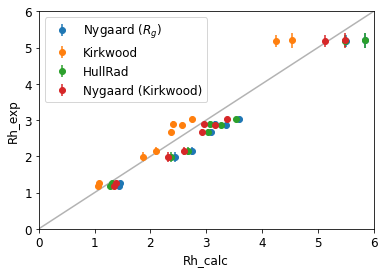

In [62]:
plt.plot([0,100], [0,100], c='0.7')
plt.errorbar([v[2] for x,v in Rh_Nyg.items()], dataset.Rh, dataset.Rh_err, fmt='o', label=r'Nygaard ($R_g$)')
plt.errorbar([v[2] for x,v in Rh_Kirk.items()], dataset.Rh, dataset.Rh_err, fmt='o', label='Kirkwood')
plt.errorbar([v[2] for x,v in Rh_HR.items()], dataset.Rh, dataset.Rh_err, fmt='o', label='HullRad')
plt.errorbar([v[2] for x,v in Rh_KirkNyg.items()], dataset.Rh, dataset.Rh_err, fmt='o', label='Nygaard (Kirkwood)')
plt.xlabel('Rh_calc')
plt.ylabel('Rh_exp')
plt.ylim(0,6)
plt.xlim(0,6)
plt.legend()

In [54]:
chi2 = ([v[2] for x,v in Rh_Nyg.items()] / dataset.Rh.values -1)**2 / (dataset.Rh_err.values/dataset.Rh.values)**2
print ('Nygaard', chi2.mean())

chi2 = ([v[2] for x,v in Rh_Kirk.items()] / dataset.Rh.values -1)**2 / (dataset.Rh_err.values/dataset.Rh.values)**2
print ('Kirkwood', chi2.mean())

chi2 = ([v[2] for x,v in Rh_HR.items()] / dataset.Rh.values -1)**2 / (dataset.Rh_err.values/dataset.Rh.values)**2
print ('HullRad', chi2.mean())

chi2 = ([v[2] for x,v in Rh_KirkNyg.items()] / dataset.Rh.values -1)**2 / (dataset.Rh_err.values/dataset.Rh.values)**2
print ('Kirkwood_correction', chi2.mean())

Nygaard 382.8547112474169
Kirkwood 120.80736343957594
HullRad 269.6203084078637
Kirkwood_correction 139.61136895419583


### Fitting correction to Kirkwood equation

In [73]:
from scipy.optimize import minimize

inv_rh = {}
for p in dataset.index:
    inv_rh[p] = 1./ (np.loadtxt(p+'/Rh_Kirk.dat'))

def kirk_scaling(k):
        
    av_rh = {}
    for p in dataset.index:
        av_rh[p] = 1./ np.average(inv_rh[p]*k, weights=dataset.weights[p])
    
    chi2 = ([v for x,v in av_rh.items()] / dataset.Rh.values -1)**2 / (dataset.Rh_err.values/dataset.Rh.values)**2
    
    return(chi2.mean())

In [74]:
res = minimize(kirk_scaling, 1., options={'disp': True})
print(res.x)

         Current function value: 3.395599
         Iterations: 7
         Function evaluations: 100
         Gradient evaluations: 46
[0.89929502]


In [75]:
Rh_KirkNew = {}
for p in dataset.index:
    Rh_KirkNew[p] = kde( np.loadtxt(p+'/Rh_Kirk.dat')*(1/res.x), dataset.weights[p] )

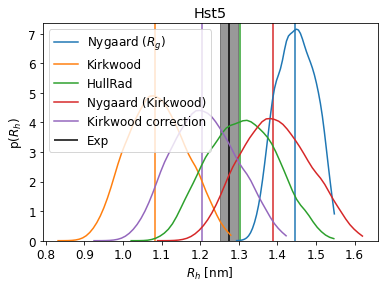

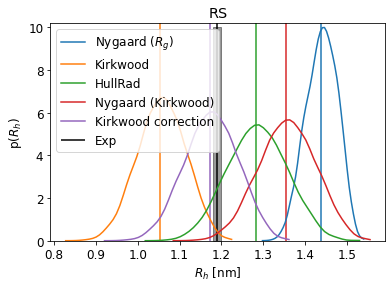

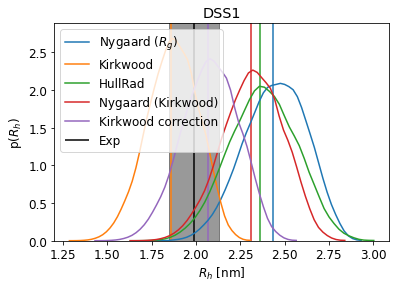

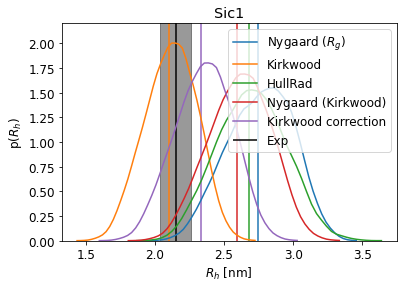

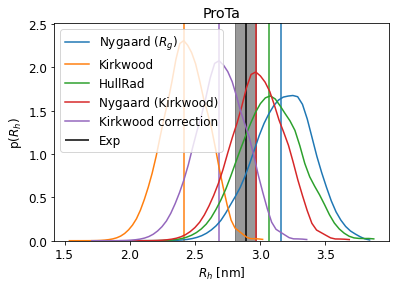

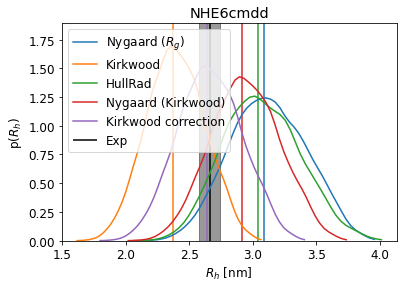

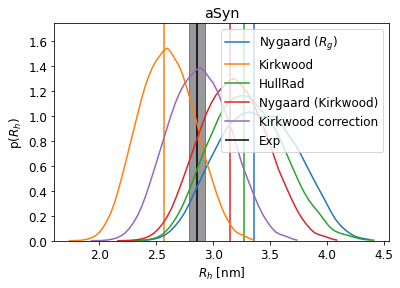

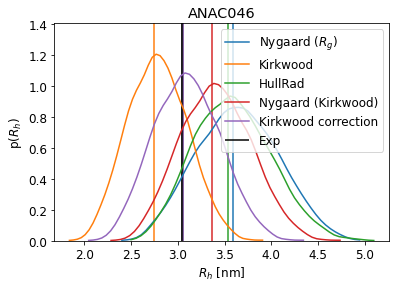

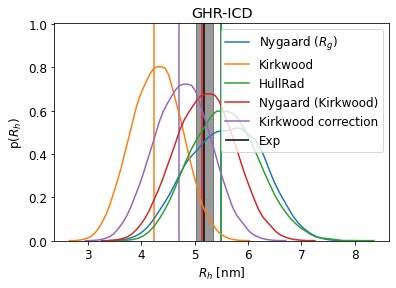

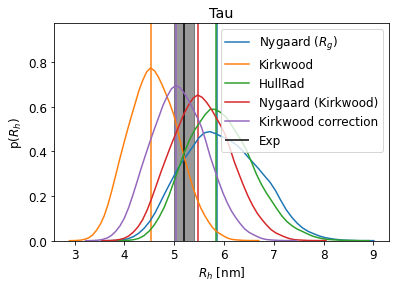

In [76]:
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['font.size'] = 12
for p in dataset.index:
    
    plt.plot(Rh_Nyg[p][0], Rh_Nyg[p][1], label=r'Nygaard ($R_g$)',color=c[0])
    plt.vlines(Rh_Nyg[p][2],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,color=c[0])
    
    plt.plot(Rh_Kirk[p][0], Rh_Kirk[p][1], label='Kirkwood',color=c[1])
    plt.vlines(Rh_Kirk[p][2],Rh_Kirk[p][1].min()-1,Rh_Kirk[p][1].max()+10,color=c[1])
    
    plt.plot(Rh_HR[p][0], Rh_HR[p][1], label='HullRad',color=c[2])
    plt.vlines(Rh_HR[p][2],Rh_HR[p][1].min()-1,Rh_HR[p][1].max()+10,color=c[2])
    
    plt.plot(Rh_KirkNyg[p][0], Rh_KirkNyg[p][1], label='Nygaard (Kirkwood)',color=c[3])
    plt.vlines(Rh_KirkNyg[p][2],Rh_KirkNyg[p][1].min()-1,Rh_KirkNyg[p][1].max()+10,color=c[3])
    
    plt.plot(Rh_KirkNew[p][0], Rh_KirkNew[p][1], label='Kirkwood correction',color=c[4])
    plt.vlines(Rh_KirkNew[p][2],Rh_KirkNew[p][1].min()-1,Rh_KirkNew[p][1].max()+10,color=c[4])
    
    plt.vlines(dataset.Rh[p],Rh_Nyg[p][1].min()-1,Rh_Nyg[p][1].max()+10,label='Exp',color='k')
    plt.ylim(0,np.max( [Rh_Nyg[p][1].max(), Rh_Kirk[p][1].max(), Rh_HR[p][1].max()] )+0.2)
    plt.fill_between((dataset.Rh[p]-dataset.Rh_err[p],dataset.Rh[p]+dataset.Rh_err[p]),0,10,color='k',alpha=0.4)
    plt.title(p)
    plt.ylabel(r'p($R_h$)')
    plt.xlabel(r'$R_h$ [nm]')
    plt.legend()
    #plt.savefig(p+'.png', dpi=300, facecolor='w', edgecolor='w', orientation='portrait')
    plt.show()

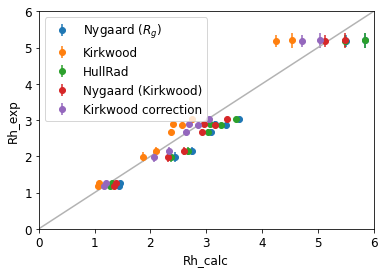

In [77]:
plt.plot([0,100], [0,100], c='0.7')
plt.errorbar([v[2] for x,v in Rh_Nyg.items()], dataset.Rh, dataset.Rh_err, fmt='o', label=r'Nygaard ($R_g$)')
plt.errorbar([v[2] for x,v in Rh_Kirk.items()], dataset.Rh, dataset.Rh_err, fmt='o', label='Kirkwood')
plt.errorbar([v[2] for x,v in Rh_HR.items()], dataset.Rh, dataset.Rh_err, fmt='o', label='HullRad')
plt.errorbar([v[2] for x,v in Rh_KirkNyg.items()], dataset.Rh, dataset.Rh_err, fmt='o', label='Nygaard (Kirkwood)')
plt.errorbar([v[2] for x,v in Rh_KirkNew.items()], dataset.Rh, dataset.Rh_err, fmt='o', label='Kirkwood correction')
plt.xlabel('Rh_calc')
plt.ylabel('Rh_exp')
plt.ylim(0,6)
plt.xlim(0,6)
plt.legend()